In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

import evosax

from typing import NamedTuple
from functools import partial
import math

In [3]:
import xylo
import xylo.types as t
import xylo.woods
import xylo.cut

import xylo.receptance as r
import xylo.sweep as xs

import xylo.loss.receptance as xlr

In [288]:
CN4 = 40
CS4 = 41
DN4 = 42
DS4 = 43
EN4 = 44
FN4 = 45
FS4 = 46
GN4 = 47
GS4 = 48
AN4 = 49
CN8 = 88

def note_to_freq(note, base=442):
  offset = note - AN4
  return math.pow(2, offset / 12) * base

print(note_to_freq(CN4, base=440), " expect 261")
print(note_to_freq(AN4, base=440), " expect 440")
print(note_to_freq(56, base=440), " expect 659")
print(note_to_freq(AN4+12, base=440), " expect 880")

# based on yamaha
note_to_len_dict = {
    45: 380,
    46: 375,
    47: 370,
    48: 365,
    49: 360,
    50: 355,
    51: 350,
    52: 340,
    53: 335,
    54: 330,
    55: 325,
    56: 320,
    57: 310,
    58: 305,
    59: 300,
    60: 295,
    61: 290,
    62: 285,
    63: 280,
    64: 270,
    65: 265,
    66: 260,
    68: 250,
    69: 240,
    70: 235,
    71: 230,
    72: 225,
    73: 220,
    74: 215,
    75: 210,
    76: 200,
    77: 195,
    78: 190,
    79: 185,
    80: 180,
    81: 170,
    82: 165,
    83: 160,
    84: 155,
    85: 150,
    86: 145,
    87: 140,
    88: 130
}
def note_to_len(note):
    return note_to_len_dict[note] / 1000


261.6255653005986  expect 261
440.0  expect 440
659.2551138257398  expect 659
880.0  expect 880


In [289]:
note = 59

bar_default = t.BarProps(width = 0.040, depth = 0.020, length = note_to_len(note), elements = 300, min_depth = 0.010)
fundamental = note_to_freq(note) # / 1.5

wood = xylo.woods.spotted_gum
# weights = jnp.array([[1, -1.0]])
# weights = jnp.array([[3, -0.75]])
# weights = jnp.array([[1, -1.0], [3, -1.0]])
# weights = jnp.array([[1, -1.0], [1.1, 1.0], [3, -1.0], [3.3, 1.0]])
# weights = jnp.array([[1, -1.0], [3, -0.75], [6, -0.5]])
# weights = jnp.array([[0.5, 0.1], [1, -1.0], [2, 0.1], [3, -0.75], [4, 0.1], [6, -0.5]])
# weights = jnp.array([[1, -1.0]])
# weights = jnp.array([[0.9, 0.1], [1, -1.0], [1.1, 0.1], [2.9, 0.075], [3, -0.75], [3.1, 0.075], [5.9, 0.05], [6, -0.5], [6.1, 0.05]])

# weights = jnp.array([[1, -1.0], [0.9, 1.0]]) # , [3, -0.9], [2.9, 0.9], [6, -0.8], [5.9, 0.8]])

# weights = jnp.array([[1, -1.0], [0.9, 1.0], [3, -0.9], [2.9, 0.9], [6, -0.8], [5.9, 0.8]])
# weights = jnp.array([[0.5, 1.0], [0.75, 1.0], [1, -1.0], [0.9, 1.0], [1.1, -1.0], [3, -0.9], [2.9, 0.9], [3.1, -0.9], [6, -0.8], [5.9, 0.8], [6.1, -0.8]])

# weights = jnp.array([[0.1, 1.0], [0.2, 1.0], [0.3, 1.0], [0.4, 1.0], [0.5, 1.0], [0.6, 1.0], [0.7, 1.0], [0.8, 1.0], [0.9, 1.0], [1, -1.0]]) # [3, -0.9], [2.9, 0.9]])
# weights = jnp.array([[0.1, 1.0], [0.2, 1.0], [0.3, 1.0], [0.4, 1.0], [0.5, 1.0], [0.6, 1.0], [0.7, 1.0], [0.8, 1.0], [0.9, 1.0], [1, -1.0], [3, -0.9], [2.9, 0.9]])
# weights = jnp.array([[0.1, 1.0], [0.2, 1.0], [0.3, 1.0], [0.4, 1.0], [0.5, 1.0], [0.6, 1.0], [0.7, 1.0], [0.8, 1.0], [0.9, 1.0], [1, -1.0], [3, -0.5], [2.9, 0.5], [6, -0.2], [5.9, 0.2]])

weights = jnp.array([[0.9, 1.0], [1, -1.0], [3, -0.75], [2.9, 0.75], [6, -0.5], [5.9, 0.5]])


# p = 0.1
# r1 = -1
# r2 = -0.5
# r3 = -0.25
# w = [[x/10, r1 if x == 10 else r2 if x == 30 else r3 if x == 6 else p] for x in range(1, 70)]
# weights = jnp.array(w)
print(fundamental, bar_default.length)

787.5544668360599 0.3


In [290]:
def mkBarLength(l: float):
    # if l in range [0,1] then range from 0.5*len to 1.5*len
    return bar_default.length # / 2 + bar_default.length * l

def mkCut3(x):
  bar_ = bar_default._replace(length = mkBarLength(x[-1]))
  cut_ = t.CutCubic(x[0], x[1], x[2] * bar_default.depth)
  sections_ = xylo.cut.cubic(bar_, cut_)
  return bar_, sections_

def mkCut4(x):
  bar_ = bar_default._replace(length = mkBarLength(x[-1]))
  sections_ = xylo.cut.quartic(bar_, x[0:-1])
  return bar_, sections_

def mkCutSpline(x):
  cut, length = x[0:-1], x[-1]
  bar_ = bar_default._replace(length = mkBarLength(length))
  sections_ = xylo.cut.spline(bar_, cut, max_spread=1) # , symmetric=False)
  return bar_, sections_

def loss_receptance(sections: t.Sections, wood: t.Wood, bar: t.BarProps, fundamental: float, ws: jnp.ndarray):
    # sections = xylo.cut.cubic(bar, cut)
    wsT = ws.T
    rs  = jax.vmap(lambda w: r.receptance_scalar(wood, bar, sections, w))(wsT[0] * 2 * jnp.pi * fundamental)
    # jax.debug.print("{rs}", rs=rs)
    return -jnp.dot(jnp.minimum(rs, 0.0), wsT[1])

def loss_harmonic(sections: t.Sections, wood: t.Wood, bar: t.BarProps, sweep_opts: t.FrequencySweep, target: jnp.ndarray, weights: jnp.ndarray = jnp.array([1.0, 0.0, 0.0])):
    sweep = xylo.sweep.sweep(wood, bar, sections, sweep_opts)
    diff = jnp.abs((target - sweep.harmonics) / target)
    # jax.debug.print("S={s}", s=sweep.harmonics)
    loss = diff * weights
    return jnp.sum(loss)



@jax.jit
def loss3(x):
  bar, sections = mkCut3(x)
  return loss_receptance(sections, wood, bar, fundamental, weights) # + jnp.abs(jnp.dot(x, jnp.ones(x.shape) * 0.001))

@jax.jit
def loss4(x):
  bar, sections = mkCut4(x)
  return loss_receptance(sections, wood, bar, fundamental, weights) # + jnp.abs(jnp.dot(x, jnp.ones(x.shape) * 0.001))

@jax.jit
def loss_spline(x):
  bar, sections = mkCutSpline(x)
  return loss_receptance(sections, wood, bar, fundamental, weights) # + jnp.abs(jnp.dot(x, jnp.ones(x.shape) * 0.001))

fundamental_goals = jnp.array([fundamental * 1, fundamental * 3, fundamental * 6])
loss_harm_sweep_opt = t.FrequencySweep(start_freq = fundamental * 0.1, stop_freq = fundamental * 10, num_freq = 30, bisect_iters = 2)

@jax.jit
def loss3_harmonic(x):
  bar, sections = mkCut3(x)
  return loss_harmonic(sections, wood, bar, loss_harm_sweep_opt, fundamental_goals) # + jnp.abs(jnp.dot(x, jnp.ones(x.shape) * 0.001))

@jax.jit
def loss4_harmonic(x):
  bar, sections = mkCut4(x)
  return loss_harmonic(sections, wood, bar, loss_harm_sweep_opt, fundamental_goals) # + jnp.abs(jnp.dot(x, jnp.ones(x.shape) * 0.001))

@jax.jit
def loss_spline_harmonic(x):
  bar, sections = mkCutSpline(x)
  return loss_harmonic(sections, wood, bar, loss_harm_sweep_opt, fundamental_goals) # + jnp.abs(jnp.dot(x, jnp.ones(x.shape) * 0.001))



In [291]:
num_generations = 100

rng = jax.random.key(0)
# for Cut3/Cut4
# strategy = evosax.CMA_ES(popsize = 500, num_dims=5)
strategy = evosax.OpenES(popsize = 2000, num_dims=5)
# strategy = evosax.SNES(popsize = 500, num_dims=5)
es_params = strategy.default_params.replace(init_min = 0, init_max=1, clip_min = 0, clip_max=1)

# for splines
# strategy = evosax.SNES(popsize = 500, num_dims=6)
# strategy = evosax.OpenES(popsize = 500, num_dims=10)
# es_params = strategy.default_params.replace(init_min = 0, init_max=1, clip_min = 0, clip_max=1)

es_state = strategy.initialize(rng, es_params)

for i in range(num_generations):
  rng, rng_gen, rng_eval = jax.random.split(rng, 3)
  x, es_state = strategy.ask(rng_gen, es_state, es_params)
  fitness = jax.vmap(loss_spline_harmonic, in_axes = 0)(x)
  fitness = jnp.float32(fitness)
  es_state = strategy.tell(x, fitness, es_state, es_params)
  if i % 10 == 0:
    print(f"iteration {i}")
    print(es_state.best_member, es_state.best_fitness)
    bar_, sections = mkCutSpline(es_state.best_member)
    # print(sections.depths)
    swp = xs.sweep(wood, bar_, sections, t.sweep_default)
    print(swp.harmonics, swp.harmonics / fundamental, bar_.length)

es_state.mean, es_state.best_member, es_state.best_fitness

iteration 0
[0.32314612 0.56300937 0.41625089 0.32657005 0.2609046 ] 0.08263674
[ 844.2892404  2727.91341158 5496.46088288] [1.07203917 3.46377746 6.97915016] 0.3
iteration 10
[0.24851439 0.50386146 0.32730061 0.35675506 0.35975513] 0.0031537956
[ 785.03512953 2584.08848184 5407.77641595] [0.99680106 3.28115526 6.86654275] 0.3
iteration 20
[0.24851439 0.50386146 0.32730061 0.35675506 0.35975513] 0.0031537956
[ 785.03512953 2584.08848184 5407.77641595] [0.99680106 3.28115526 6.86654275] 0.3
iteration 30
[0.24851439 0.50386146 0.32730061 0.35675506 0.35975513] 0.0031537956
[ 785.03512953 2584.08848184 5407.77641595] [0.99680106 3.28115526 6.86654275] 0.3
iteration 40
[0.24851439 0.50386146 0.32730061 0.35675506 0.35975513] 0.0031537956
[ 785.03512953 2584.08848184 5407.77641595] [0.99680106 3.28115526 6.86654275] 0.3
iteration 50
[0.24851439 0.50386146 0.32730061 0.35675506 0.35975513] 0.0031537956
[ 785.03512953 2584.08848184 5407.77641595] [0.99680106 3.28115526 6.86654275] 0.3
iterati

(Array([0.22855728, 0.48500137, 0.47410909, 0.75023135, 0.53240015],      dtype=float64),
 Array([0.24851439, 0.50386146, 0.32730061, 0.35675506, 0.35975513],      dtype=float64),
 Array(0.0031538, dtype=float32))

(Array([ 785.03512953, 2584.08848184, 5407.77641595], dtype=float64),
 Array([0.99680106, 3.28115526, 6.86654275], dtype=float64),
 0.3)

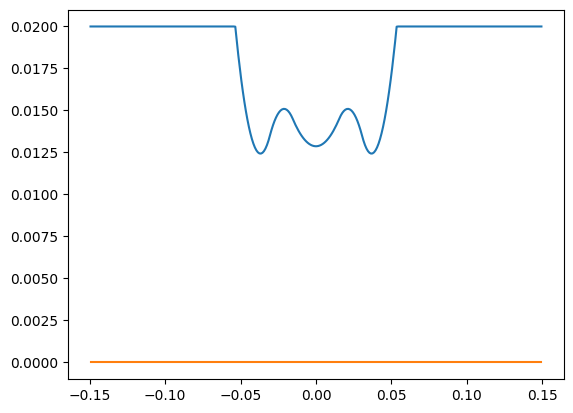

In [292]:
bar_, sections = mkCutSpline(es_state.best_member)
sections.plot(to_scale = False)

swp = xs.sweep(wood, bar_, sections, t.sweep_default)
swp.harmonics, swp.harmonics / fundamental, bar_.length



In [293]:
import optimistix
# solver = optimistix.GradientDescent(learning_rate = 0.001, rtol = 0.0000001, atol = 0.0000001)
solver = optimistix.BFGS(rtol = 1e-10, atol = 1e-10)
# solver = optimistix.NonlinearCG(rtol = 0.000001, atol = 0.000001)

solver = optimistix.BestSoFarMinimiser(solver)

# y0 = es_state.best_member

# fundamental = 440

# args = (wood, bar, fundamental, jnp.array([[0.5, 0.5], [1, -1.0], [2, 0.5], [3, -0.9], [4, 0.5], [5, -0.8]]))

sol = optimistix.minimise(lambda x,args: loss_spline(x), solver = solver, y0 = es_state.best_member, max_steps = None)



(Array([ 787.55446685, 2594.40678036, 5415.4633665 ], dtype=float64),
 Array([1.        , 3.29425696, 6.87630328], dtype=float64),
 0.3)

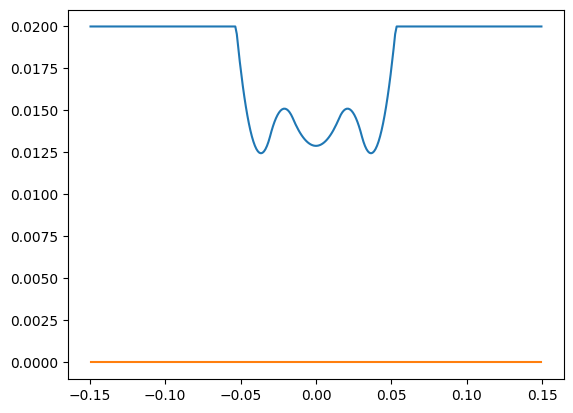

In [294]:
bar_, sections = mkCutSpline(sol.value)
sections.plot(to_scale = False)

swp = xs.sweep(wood, bar_, sections, t.sweep_default)
swp.harmonics, swp.harmonics / fundamental, bar_.length

(Array([1153.23311998, 3083.04555279, 5799.73045889], dtype=float64),
 Array([1.46432173, 3.91470772, 7.36422775], dtype=float64),
 0.3)

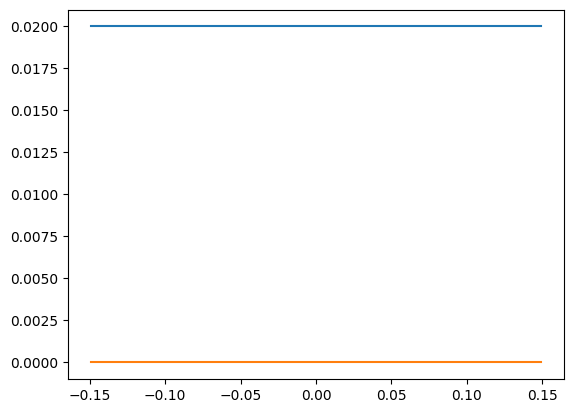

In [295]:
bar_, sections = mkCutSpline(jnp.array([1.0, 1.0, 1.0]))
sections.plot(to_scale = False)

swp = xs.sweep(wood, bar_, sections, t.sweep_default)
swp.harmonics, swp.harmonics / fundamental, bar_.length

0.0 [1153.23311998 3083.04555279 5799.73045889] [1.46432173 3.91470772 7.36422775] [1.         1.         1.         0.35333472 0.35975513] [0. 0. 0.]
0.1 [1086.33211427 3049.72912331 5685.85619293] [1.37937395 3.87240407 7.21963551] [0.92506067 0.90103476 0.79884681 0.35333472 0.35975513] [0.1 0.2 0.3]
0.2 [1009.87308197 3009.7162108  5572.37055126] [1.28228983 3.82159754 7.07553672] [0.85012133 0.80206953 0.59769361 0.35333472 0.35975513] [0.2 0.4 0.6]
0.30000000000000004 [ 921.57369305 2961.12855322 5460.75588468] [1.17017137 3.75990319 6.93381361] [0.775182   0.70310429 0.39654042 0.35333472 0.35975513] [0.3 0.6 0.9]
0.4 [ 874.70798982 2908.56123355 5429.58724715] [1.11066349 3.69315566 6.89423713] [0.70024267 0.60413906 0.32948935 0.35333472 0.35975513] [0.4 0.8 1. ]
0.5 [ 850.27157364 2850.7559973  5435.37472215] [1.07963526 3.61975726 6.9015858 ] [0.62530334 0.50517382 0.32948935 0.35333472 0.35975513] [0.5 1.  1. ]
0.6000000000000001 [ 841.14160471 2811.46562324 5433.63378517] 

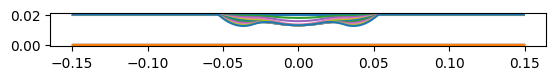

In [303]:
for i in jnp.arange(0.0, 1.1, 0.1):
    xi = jnp.arange(1, len(sol.value) - 1)
    ii = jnp.minimum(xi * i, 1)

    vv = jnp.concat([1 - (1 - sol.value[0:-2]) * ii, sol.value[-2:]])
    bar_, sections = mkCutSpline(vv)
    sections.plot(to_scale = False)
    
    swp = xs.sweep(wood, bar_, sections, t.sweep_default)
    print(i, swp.harmonics, swp.harmonics / fundamental, vv, ii)

In [271]:
sol.value[0:-2], sol.value[-2:]

(Array([0.25352795, 0.50700718, 0.33254144], dtype=float64),
 Array([0.34858063, 0.35975513], dtype=float64))

In [268]:
sol.value

Array([0.25352795, 0.50700718, 0.33254144, 0.34858063, 0.35975513],      dtype=float64)

In [285]:
jnp.arange(start = 1, stop = 5, step = 0.2)

Array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. , 3.2, 3.4,
       3.6, 3.8, 4. , 4.2, 4.4, 4.6, 4.8], dtype=float64)

In [358]:
def xsweep(wood):
    vv = jnp.array([1.0, 0.34858063, 0.35975513])
    bar_, sections = mkCutSpline(vv)
    sections.plot(to_scale = True)
    
    swp = xs.sweep(wood, bar_, sections, t.sweep_default)
    print(wood)
    print(i, swp.harmonics, swp.harmonics / fundamental, vv, ii)
    print("")

Wood(rho=990, E=26100000000.0, G=8758389261.744967, nu=0.49)
1.0 [1153.23311998 3083.04555279 5799.73045889] [1.46432173 3.91470772 7.36422775] [1.         0.34858063 0.35975513] [1. 1. 1.]



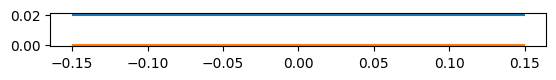

In [359]:
xsweep(t.Wood.make_E_nu(E = 26.100e9, nu = 0.49, rho = 990))

Wood(rho=1114, E=26100000000.0, G=8758389261.744967, nu=0.49)
1.0 [1087.15660409 2906.39704614 5467.4247219 ] [1.38042085 3.69040767 6.94228139] [1.         0.34858063 0.35975513] [1. 1. 1.]



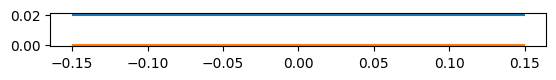

In [414]:
xsweep(t.Wood.make_E_nu(E = 26.100e9, nu = 0.49, rho = 1114))

Wood(rho=990, E=23150000000.0, G=7768456375.838926, nu=0.49)
1.0 [1086.10634422 2903.58928849 5462.14285458] [1.37908728 3.68684251 6.93557472] [1.         0.34858063 0.35975513] [1. 1. 1.]



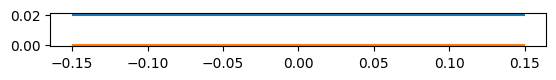

In [422]:
xsweep(t.Wood.make_E_nu(E = 23.150e9, nu = 0.49, rho = 990))

Wood(rho=990, E=26100000000.0, G=952554744.5255475, nu=12.7)
1.0 [1086.0524148  2560.41973279 4229.77439505] [1.3790188  3.25110178 5.37077062] [1.         0.34858063 0.35975513] [1. 1. 1.]



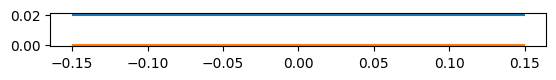

In [445]:
xsweep(t.Wood.make_E_nu(E = 26.100e9, nu = 12.7, rho = 990))

Wood(rho=990, E=24500000000.0, G=1550632911.392405, nu=6.9)
1.0 [1081.77351702 2688.10471385 4651.23559553] [1.37358565 3.41323023 5.90592244] [1.         0.34858063 0.35975513] [1. 1. 1.]



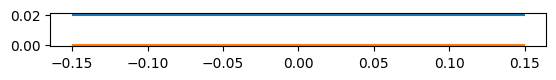

In [459]:
xsweep(t.Wood.make_E_nu(E = 24.500e9, nu = 6.9, rho = 990))
# 1400000000.0 / 1531250000.0

In [480]:
def xsweep19(wood):
    vv = jnp.array([1.0, 1.0, 1.0])
    bar_, sections = mkCutSpline(vv)
    sections = sections._replace(depths = sections.depths * (19.5 / 20))
    sections.plot(to_scale = True)
    
    swp = xs.sweep(wood, bar_, sections, t.sweep_default)
    print(wood)
    print(i, swp.harmonics, swp.harmonics / fundamental, vv, ii)
    print("")

Wood(rho=1059, E=26100000000.0, G=8758389261.744967, nu=0.49)
1.0 [1088.0402664  2912.82460477 5488.96375706] [1.38154288 3.69856909 6.96963066] [1. 1. 1.] [1. 1. 1.]



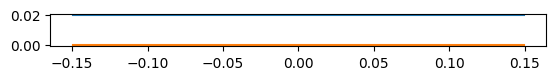

In [487]:
xsweep19(t.Wood.make_E_nu(E = 26.100e9, nu = 0.49, rho = 1059))